# Notebook Setup

In [1]:
# IMPORT ENVIRONMENT VARIABLES
import os
from datetime import datetime

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

le = preprocessing.LabelEncoder()

In [ ]:
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Don't wrap lines
pd.set_option("display.max_colwidth", None)  # Show full column content (if it's text)

## Set Up Folder Path

In [3]:
# Folder containing the files, in this case "data" is located in the current working directory
folder_path = "./data"

## Create Region Mapping Assignment and Read In Files

In [ ]:
# Category assignment map
category_map = {
    "Northeast": "Marcus",
    "Northeast ": "Marcus",
    "Mid-Atlantic": "Olivia",
    "Southeast": "Olivia",
    "Southwest": "Marcus",
    "Midwest": "Marcus",
    "Midwest ": "Marcus",
    "Northwest": "Marcus",
    "California": "Olivia",
    "Great Lakes": "Marcus",
}

# Read all Excel files
all_files = [f for f in os.listdir(folder_path) if f.endswith(".xlsx")]

dataframes = []

for file in all_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_excel(file_path)

        if len(df) < 3:
            print(f"Skipping {file} because it has less than 3 rows.")
            continue

        if "Category" not in df.columns:
            print(f"Skipping {file} because 'Category' column is missing.")
            continue

        df["RVP"] = df["Category"].map(category_map).fillna("N/A")

        # Extract the month from the filename
        date_part = file.split("_to_")[0].split("_")[-1]  # Gets data as '2025-05-01'
        month_name = datetime.strptime(date_part, "%Y-%m-%d").strftime(
            "%B"
        )  # Gets Month Name
        date_num = int(date_part[-5:-3])

        df["Report Month"] = month_name
        df["Month Number"] = date_num

        dataframes.append(df)

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print("Combined dataframe created successfully.")
else:
    print("No valid dataframes to combine.")

Combined dataframe created successfully.


### Spot Check

In [5]:
combined_df.head(2)

,Seat ID,Name,Invited Email Address,Date Invited,Date Activated,Coach Level,Category,Current Seat Type,Days Active,Searches Performed,Profile Views,Leads Saved,Total Leads Saved,Accounts Saved,Total Accounts Saved,Total Lists Created,InMails Sent,InMails Acceptance Rate,Messages Sent,Smart Links Created,Smart Link Views,Total Connections,Connection Requests Accepted,SSI - Overall Score,SSI - Establish your professional brand,SSI - Find the right people,SSI - Engage with insights,SSI - Build relationships,RVP,Report Month,Month Number,Date Removed
0,283878287,Ryan Gallagher,ryan.gallagher@example.com,2014-09-16,2014-11-13 00:00:00,Expert,Southwest,Team Member,29,2,13,10,6,22,101,1,31,0.00,0,0,0,573,4,46.28,10.96,6.43,1.54,23.75,Marcus,January,1,NaN
1,417608741,Philip Kennedy,philip.kennedy@example.com,2014-09-16,2014-11-13 00:00:00,Advanced,Southwest,Team Member,30,73,307,88,1055,13,929,11,110,3.48,2,0,0,3755,105,65.64,19.46,12.06,14.48,24.25,Marcus,January,1,NaN


In [6]:
# Check the available columns

combined_df.columns.tolist()

['Seat ID',
 'Name',
 'Invited Email Address',
 'Date Invited',
 'Date Activated',
 'Coach Level',
 'Category',
 'Current Seat Type',
 'Days Active',
 'Searches Performed',
 'Profile Views',
 'Leads Saved',
 'Total Leads Saved',
 'Accounts Saved',
 'Total Accounts Saved',
 'Total Lists Created',
 'InMails Sent',
 'InMails Acceptance Rate',
 'Messages Sent',
 'Smart Links Created',
 'Smart Link Views',
 'Total Connections',
 'Connection Requests Accepted',
 'SSI - Overall Score',
 'SSI - Establish your professional brand',
 'SSI - Find the right people',
 'SSI - Engage with insights',
 'SSI - Build relationships',
 'RVP',
 'Report Month',
 'Month Number',
 'Date Removed']

## Set Old Employees and Set Name Fixes

In [ ]:
# The original code in this section has been removed due to anonymization
# This is where you can enter a list of old employees and create a dictionary for name corrections

# Set list of old employees
old_employees = ("Old Employee", "Another Employee")

# Set dictionary of name corrections to maintain consistency if names change or people get married/divorced, etc.
# Example: "Greg Rowling": "Gregory Rowling"

renames = {"Old Name": "New Name", "Old Name2": "New Name2"}

## Aggregate SSI Score Table
* Process Name Fixes
* Filter Old Employees
* Create Pivot Table By Employee for Each Month
* Calculate Curent - Last change
* Calculate Most Full Average

In [ ]:
# Replace inconsistent names
tmp = combined_df.copy()
tmp["Name"] = tmp["Name"].replace(renames, regex=False)

# Filter so RVP is "Marcus" and remove old employees
filter = tmp[tmp["RVP"] == "Marcus"]
filter = filter[~filter["Name"].isin(old_employees)]

# Create a pivot table
pt = pd.pivot_table(
    filter,
    index="Name",
    columns="Report Month",
    values="SSI - Overall Score",
    aggfunc="sum",
)

pt = pt.replace(0, np.nan)

# Add an Average SSI Score for all
pt["Average SSI Score"] = pt.mean(axis=1)

# Get the sorted months (assuming columns are strings like "January", "February", ...)
# If Report Month is datetime, adjust accordingly
months = [col for col in pt.columns if col not in ["Change", "Average SSI Score"]]
months_sorted = sorted(months, key=lambda x: pd.to_datetime(x, format="%B"))

if len(months_sorted) >= 2:
    last_month = months_sorted[-1]
    prev_month = months_sorted[-2]
    pt["Change"] = pt[last_month] - pt[prev_month]
else:
    # Fallback if not enough months to calculate change
    pt["Change"] = np.nan

# Reorder columns (keep the months sorted in order)
pt = pt[months_sorted + ["Change", "Average SSI Score"]]

In [9]:
# Print the pivot table output
pt

Report Month,January,February,March,April,May,June,July,August,September,Change,Average SSI Score
Name,,,,,,,,,,,
Aaron Price,NaN,NaN,NaN,NaN,NaN,67.63,41.18,55.27,58.94,3.67,55.755000
Adam Christensen,NaN,66.62,NaN,NaN,NaN,NaN,NaN,NaN,50.05,NaN,58.335000
Adam Koch,NaN,NaN,NaN,59.64,NaN,42.62,23.17,NaN,43.77,NaN,42.300000
Adrian Campos,52.86,NaN,58.98,27.56,69.88,45.43,NaN,44.11,NaN,NaN,49.803333
Alexandra Durham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.75,53.36,-2.39,54.555000
Amanda Gonzalez,46.04,69.70,50.61,NaN,68.16,NaN,NaN,NaN,43.59,NaN,55.620000
Amanda Johnson,67.58,NaN,NaN,NaN,NaN,48.36,NaN,NaN,70.14,NaN,62.026667
Amanda Sanchez,51.88,65.78,52.15,70.61,52.13,NaN,54.78,NaN,51.58,NaN,56.987143
Amy Evans,NaN,68.47,56.33,NaN,54.37,NaN,64.92,41.23,NaN,NaN,57.064000


In [ ]:
# Save the file
pt.to_excel("./reporting/Average SSI Scores.xlsx", index=True)

## Current Coach Level

* Filter Region = Marcus
* Filter Month = Max Month
* Pivot Table = By Name, Column = Report Month, Values = Coach Level (Text)

In [ ]:
# Replace inconsistent names
tmp = combined_df.copy()
tmp["Name"] = tmp["Name"].replace(renames, regex=False)

# Filter so RVP is "Marcus" and remove old employees
filter = tmp[tmp["RVP"] == "Marcus"]
filter = filter[~filter["Name"].isin(old_employees)]
filter = filter[filter["Month Number"] == filter["Month Number"].max()]

# Create a pivot table
pt = pd.pivot_table(
    filter,
    index="Name",
    columns="Report Month",
    values="Coach Level",
    aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
)

# Print the pivot table output
pt

Report Month,September
Name,
Aaron Price,Unavailable
Adam Christensen,Intermediate
Adam Koch,Proficient
Alexandra Durham,Intermediate
Amanda Gonzalez,Advanced
Amanda Johnson,Expert
Amanda Sanchez,Proficient
Anna Johnson,Advanced
Ashley Martin,Advanced


In [ ]:
# Save The File
pt.to_excel("./reporting/Current Coach Level.xlsx", index=True)

## Statistical Analysis

### Create a temporary dataframe to work with

In [68]:
combined_df_tmp = combined_df.copy()

In [69]:
combined_df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Seat ID                                  1068 non-null   int64         
 1   Name                                     1068 non-null   object        
 2   Invited Email Address                    1068 non-null   object        
 3   Date Invited                             1068 non-null   datetime64[ns]
 4   Date Activated                           1036 non-null   object        
 5   Coach Level                              1068 non-null   object        
 6   Category                                 1068 non-null   object        
 7   Current Seat Type                        1068 non-null   object        
 8   Days Active                              1068 non-null   int64         
 9   Searches Performed                       

In [46]:
combined_df_tmp.head()

,Seat ID,Name,Invited Email Address,Date Invited,Date Activated,Coach Level,Category,Current Seat Type,Days Active,Searches Performed,Profile Views,Leads Saved,Total Leads Saved,Accounts Saved,Total Accounts Saved,Total Lists Created,InMails Sent,InMails Acceptance Rate,Messages Sent,Smart Links Created,Smart Link Views,Total Connections,Connection Requests Accepted,SSI - Overall Score,SSI - Establish your professional brand,SSI - Find the right people,SSI - Engage with insights,SSI - Build relationships,RVP,Report Month,Month Number,Date Removed
0,283878287,Ryan Gallagher,ryan.gallagher@example.com,2014-09-16,2014-11-13 00:00:00,Expert,Southwest,Team Member,29,2,13,10,6,22,101,1,31,0.00,0,0,0,573,4,46.28,10.96,6.43,1.54,23.75,Marcus,January,1,NaN
1,417608741,Philip Kennedy,philip.kennedy@example.com,2014-09-16,2014-11-13 00:00:00,Advanced,Southwest,Team Member,30,73,307,88,1055,13,929,11,110,3.48,2,0,0,3755,105,65.64,19.46,12.06,14.48,24.25,Marcus,January,1,NaN
2,907395948,Anna Johnson,anna.johnson@example.com,2022-07-05,2022-10-17 00:00:00,Intermediate,Southwest,Team Member,20,43,76,15,578,70,923,9,81,0.15,2,0,0,426,12,58.17,10.52,10.70,8.89,24.25,Marcus,January,1,NaN
3,757144854,Lawrence Wang,lawrence.wang@example.com,2018-03-09,2018-03-10 00:00:00,Proficient,Mid-Atlantic,Team Member,30,84,48,17,1705,53,1028,6,87,0.17,0,0,0,1434,30,55.32,13.37,9.77,6.14,23.19,Olivia,January,1,NaN
4,119765575,Nathan Perez,nathan.perez@example.com,2021-06-20,2019-01-11 00:00:00,Advanced,Southeast,Team Member,13,38,53,181,21,96,109,4,50,0.00,0,0,0,327,1,46.89,7.28,10.04,6.58,23.77,Olivia,January,1,NaN


In [72]:
combined_df_tmp = combined_df_tmp.dropna(
    axis=1, how="all"
)  # Drop rows with NA for all columns

In [73]:
# 1 – see how many non‑null entries each column has
print(combined_df_tmp.isna().sum().sort_values(ascending=False).head(15))

# 2 – count NaNs per row
print(combined_df_tmp.isna().sum(axis=1).value_counts().head())

Date Activated           32
Name                      0
Seat ID                   0
Invited Email Address     0
Date Invited              0
Coach Level               0
Category                  0
Current Seat Type         0
Days Active               0
Searches Performed        0
Profile Views             0
Leads Saved               0
Total Leads Saved         0
Accounts Saved            0
Total Accounts Saved      0
dtype: int64
0    1036
1      32
Name: count, dtype: int64


In [74]:
# Simplify the dataset so that we have no rows with an empty
combined_df_tmp = combined_df_tmp[~combined_df_tmp["SSI - Overall Score"].isna()]

### Split into X and y

In [75]:
# Select only the relevant columns for our analysis
X = combined_df_tmp[
    [
        "Days Active",
        "Searches Performed",
        "Profile Views",
        "Leads Saved",
        "Total Leads Saved",
        "Accounts Saved",
        "Total Accounts Saved",
        "Total Lists Created",
        "InMails Sent",
        "Messages Sent",
        "Smart Links Created",
    ]
].copy()

y = combined_df_tmp["SSI - Overall Score"].copy()

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Days Active           1068 non-null   int64
 1   Searches Performed    1068 non-null   int64
 2   Profile Views         1068 non-null   int64
 3   Leads Saved           1068 non-null   int64
 4   Total Leads Saved     1068 non-null   int64
 5   Accounts Saved        1068 non-null   int64
 6   Total Accounts Saved  1068 non-null   int64
 7   Total Lists Created   1068 non-null   int64
 8   InMails Sent          1068 non-null   int64
 9   Messages Sent         1068 non-null   int64
 10  Smart Links Created   1068 non-null   int64
dtypes: int64(11)
memory usage: 91.9 KB


In [77]:
X.head()

,Days Active,Searches Performed,Profile Views,Leads Saved,Total Leads Saved,Accounts Saved,Total Accounts Saved,Total Lists Created,InMails Sent,Messages Sent,Smart Links Created
0,29,2,13,10,6,22,101,1,31,0,0
1,30,73,307,88,1055,13,929,11,110,2,0
2,20,43,76,15,578,70,923,9,81,2,0
3,30,84,48,17,1705,53,1028,6,87,0,0
4,13,38,53,181,21,96,109,4,50,0,0


In [78]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1068 entries, 0 to 1067
Series name: SSI - Overall Score
Non-Null Count  Dtype  
--------------  -----  
1068 non-null   float64
dtypes: float64(1)
memory usage: 8.5 KB


In [79]:
y.head()

0    46.28
1    65.64
2    58.17
3    55.32
4    46.89
Name: SSI - Overall Score, dtype: float64

In [57]:
y[y.isna()]

Series([], Name: SSI - Overall Score, dtype: float64)

### Create a Grid Search for the best model

In [80]:
# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1856845
)


# Define pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),  # Step 1: scaling
        ("pca", PCA()),  # ADD: PCA
        ("model", LinearRegression()),  # Step 2: a placeholder for model swapping
    ]
)

param_grid = [
    # Linear Regression
    {
        "pca__n_components": [2, 5, 7],
        "model": [LinearRegression()],
        # No hyperparameters to tune for basic LinearRegression
    },
    # Ridge Regression
    {
        "model": [Ridge(random_state=1856843)],
        "pca__n_components": [2, 5, 7],
        "model__alpha": [0.1, 1.0, 10.0, 100.0],
    },
    # Lasso Regressiona
    {
        "model": [Lasso(random_state=1856843)],
        "pca": ["passthrough"],
        "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    },
    # ElasticNet Regression
    {
        "model": [ElasticNet(random_state=1856843)],
        "model__alpha": [0.01, 0.1, 1.0, 10.0],
        "pca": ["passthrough"],
        "model__l1_ratio": [0.1, 0.5, 0.9],
    },
    # Decision Tree Regressor
    {
        "scaler": ["passthrough"],
        "model": [DecisionTreeRegressor(random_state=1856843)],
        "model__max_depth": [3, 5, 10, 12, 15],
        "pca__n_components": [2, 5, 7],
        "model__min_samples_split": [2, 5, 10],
    },
    # Random Forest Regressor
    {
        "scaler": ["passthrough"],
        "model": [RandomForestRegressor(random_state=1856843)],
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5, 10, 15, None],
        "pca": ["passthrough"],
        "model__min_samples_split": [2, 5, 10],
    },
    # XGBoost Regressor
    {
        "scaler": ["passthrough"],
        "model": [XGBRegressor(random_state=1856843, verbosity=0)],
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5, 7, 9, 10],
        "pca": ["passthrough"],
        "model__learning_rate": [0.01, 0.1, 0.2, 0.5],
    },
    # HistGradientBoosting Regressor
    {
        "model": [HistGradientBoostingRegressor(random_state=1856843)],
        "model__max_iter": [50, 100, 200],
        "model__max_depth": [3, 5, 7, None],
        "pca__n_components": [2, 5, 7],
        "model__learning_rate": [0.01, 0.1, 0.2, 0.5],
    },
    # K-Nearest Neighbors Regressor
    {
        "model": [KNeighborsRegressor()],
        "model__n_neighbors": [3, 5, 7, 9],
        "pca__n_components": [2, 5, 7],
        "model__weights": ["uniform", "distance"],
    },
]


# Run Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Results (Train)
print("\n")
print(f"Best Model: {grid.best_estimator_}")
print(f"Best R^2 Score: {grid.best_score_:.4f}")
print(f"Best Params: {grid.best_params_}")

# Results (Test)
test_score = grid.best_estimator_.score(X_test, y_test)
print(f"Test R^2 Score: {test_score:.4f}")

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


Best Model: Pipeline(steps=[('scaler', 'passthrough'), ('pca', 'passthrough'),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
           

### PCA With Loadings

In [82]:
# Get best pipeline from grid search
best_pipe = grid.best_estimator_

# Extract PCA step
best_pca = best_pipe.named_steps["pca"]

if isinstance(best_pca, PCA):
    # Get components (shape: n_components x n_features)
    components = best_pca.components_

    # Map components to feature names
    loadings_df = pd.DataFrame(
        components.T,
        index=X.columns,
        columns=[f"PC{i+1}" for i in range(components.shape[0])],
    )

    print(loadings_df)

    # Select loadings for the first 3 PCs (or fewer if less than 3)
    n_plot = min(3, components.shape[0])
    loadings_subset = loadings_df.iloc[:, :n_plot]

    # Plot loadings for each PC
    fig, axes = plt.subplots(1, n_plot, figsize=(6 * n_plot, 6), sharey=True)

    # When only one PC, axes is not a list by default
    if n_plot == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        pc = loadings_subset.columns[i]
        sns.barplot(x=loadings_subset[pc], y=loadings_subset.index, ax=ax, orient="h")
        ax.set_title(f"Loadings for {pc}")
        ax.set_xlabel("Loading")
        ax.set_ylabel("Feature")
        ax.axvline(0, color="black", linewidth=0.8)

    plt.tight_layout()
    plt.show()

else:
    print("PCA step was set to 'passthrough' (no PCA used), so no loadings to display.")

PCA step was set to 'passthrough' (no PCA used), so no loadings to display.


In [ ]:
# In a historical model, PCA was used. This would have shown our PCA if PCA wasn't set to passthrough

# # Extract PCA loadings (components)
# # Get best pipeline from grid search
# best_pipe = grid.best_estimator_

# # Get PCA step
# best_pca = best_pipe.named_steps['pca']

# # Get components (shape: n_components x n_features)
# components = best_pca.components_

# # Map components to feature names
# loadings_df = pd.DataFrame(components.T, index=X.columns,
#                            columns=[f'PC{i+1}' for i in range(components.shape[0])])


# print(loadings_df)


# # Select loadings for the first 3 PCs
# loadings_subset = loadings_df.iloc[:, :3]

# # Plot loadings for each PC
# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# for i, ax in enumerate(axes):
#     pc = loadings_subset.columns[i]
#     sns.barplot(x=loadings_subset[pc], y=loadings_subset.index, ax=ax, orient='h')
#     ax.set_title(f'Loadings for {pc}')
#     ax.set_xlabel('Loading')
#     ax.set_ylabel('Feature')
#     ax.axvline(0, color='black', linewidth=0.8)

# plt.tight_layout()
# plt.show()

### Feature Importance

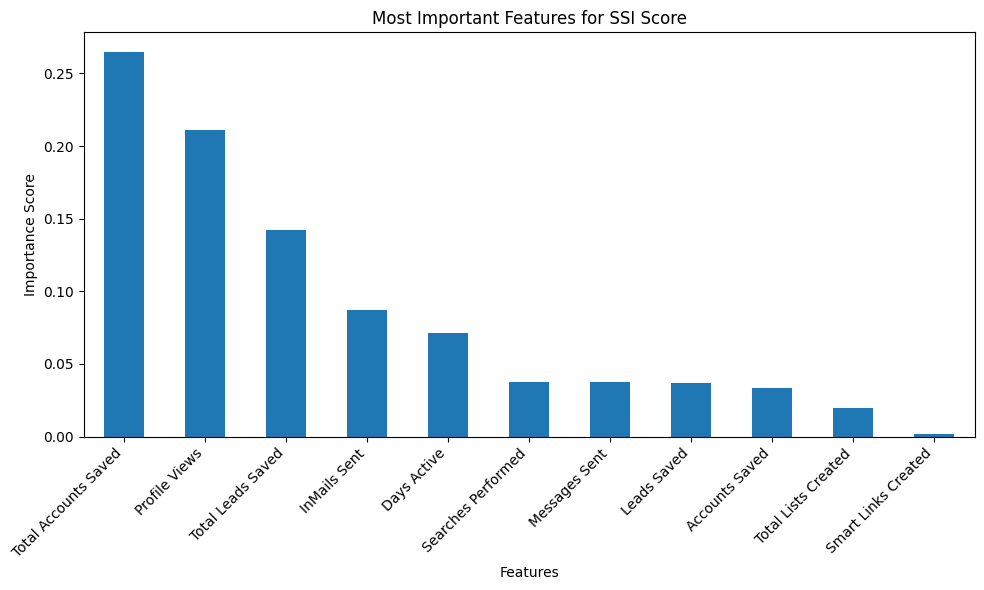

In [ ]:
# Extract the best pipeline and model
best_pipeline = grid.best_estimator_

# Calculate permutation importance
result = permutation_importance(
    best_pipeline, X, y, n_repeats=10, random_state=1856845, n_jobs=-1
)

# Create a pandas Series with feature names
feature_importance = pd.Series(result.importances_mean, index=X.columns)

# Sort features by importance
feature_importance = feature_importance.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
feature_importance.plot(kind="bar")
plt.title("Most Important Features for SSI Score")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("./reporting/Feature Importance.png", dpi=300)
plt.show()

### Top 5 Features

In [61]:
df = feature_importance[:5].to_frame(name="Importance Score")
df.index.name = "Metric"
df.reset_index(inplace=True)
df

,Metric,Importance Score
0,Total Accounts Saved,0.265058
1,Profile Views,0.211104
2,Total Leads Saved,0.141929
3,InMails Sent,0.087269
4,Days Active,0.071297


### Partial Dependence

Backing up the feature importance claims

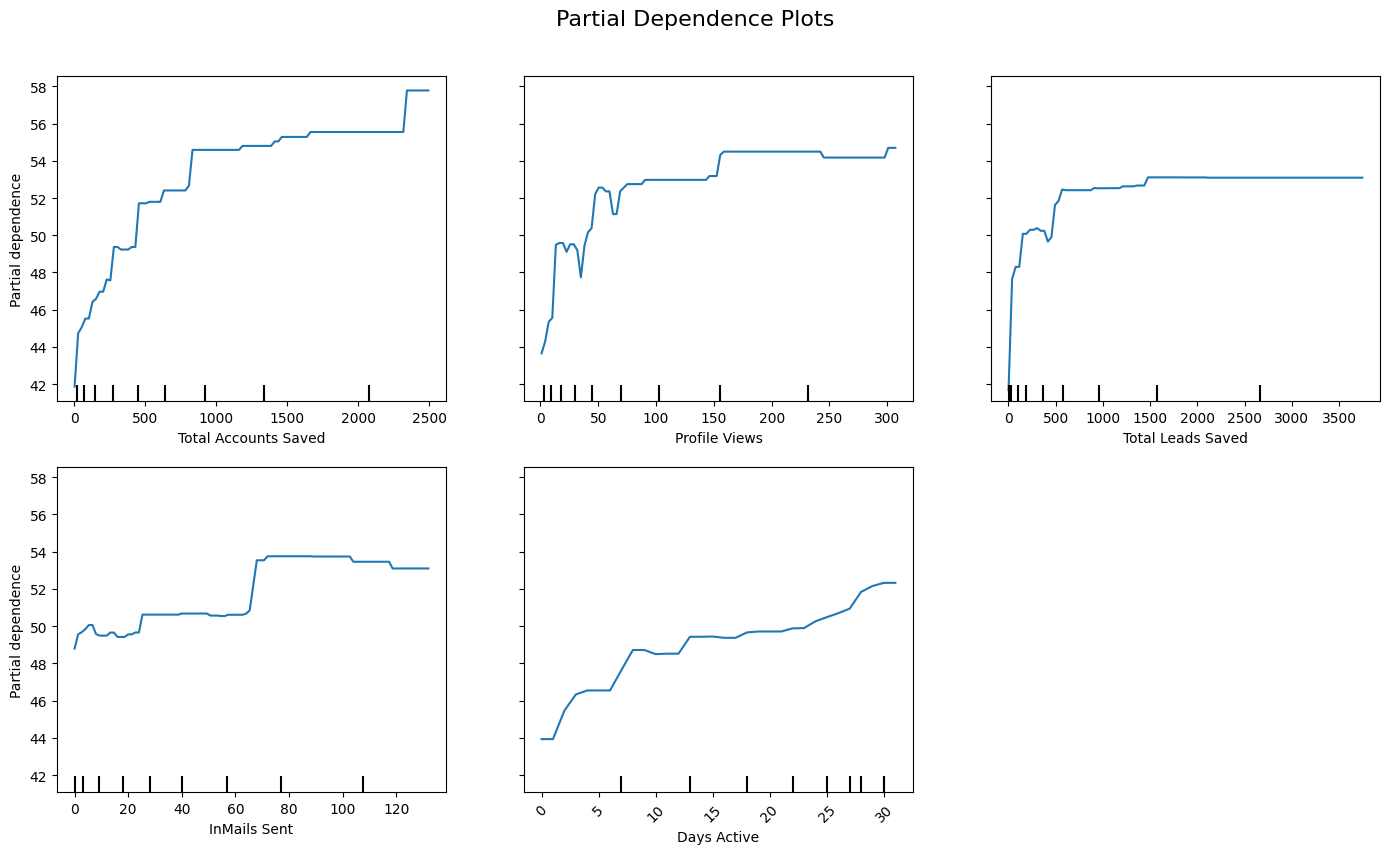

In [63]:
best_pipeline = grid.best_estimator_
feature_names = X.columns.tolist()
features_to_plot = list(df["Metric"])

fig, ax = plt.subplots(figsize=(14, (len(list(df["Metric"])) / 3) * 5))

PartialDependenceDisplay.from_estimator(
    best_pipeline,
    X.astype(float),
    features_to_plot,
    feature_names=feature_names,
    kind="average",
    ax=ax,
)

plt.xticks(rotation=45)

fig.suptitle("Partial Dependence Plots", fontsize=16, y=1.02)

plt.tight_layout()

plt.savefig("./reporting/Partial Dependence.png", dpi=300, bbox_inches="tight")
plt.show()

### Correlations

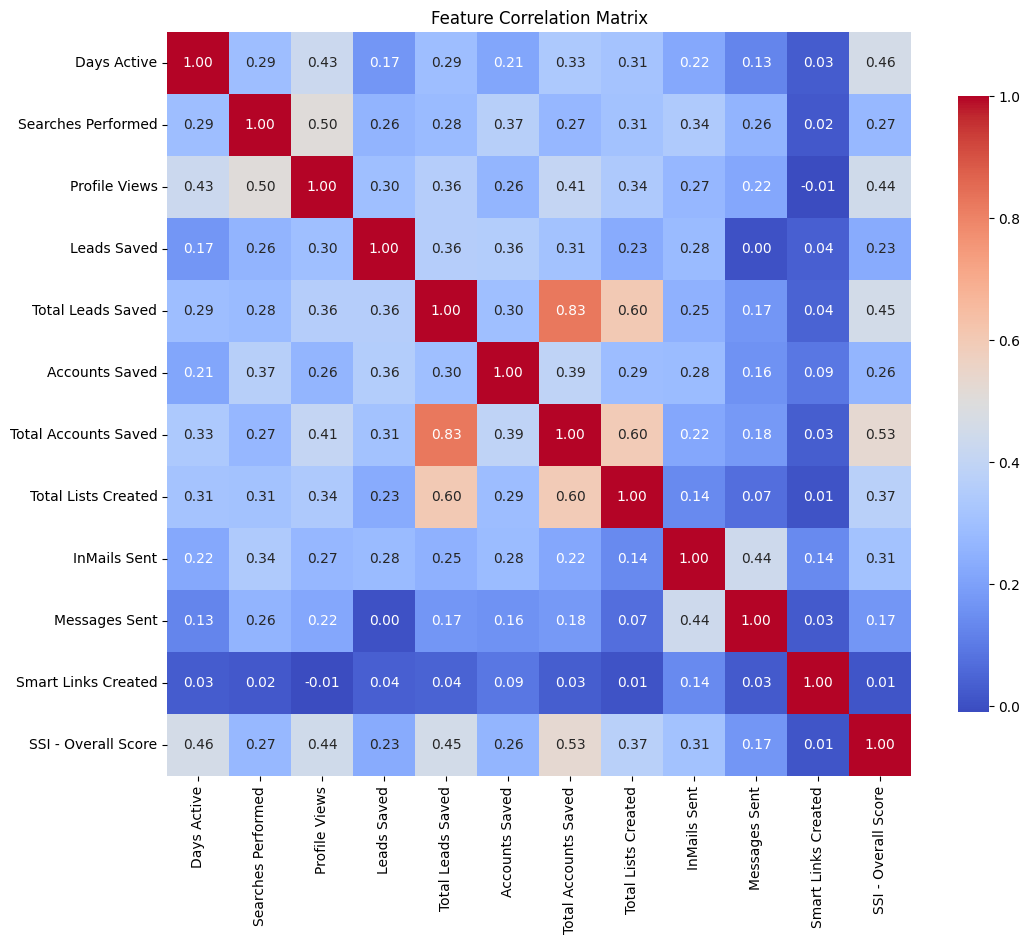

In [83]:
# Calculate correlation matrix
corr = (
    combined_df_tmp[
        [
            "Days Active",
            "Searches Performed",
            "Profile Views",
            "Leads Saved",
            "Total Leads Saved",
            "Accounts Saved",
            "Total Accounts Saved",
            "Total Lists Created",
            "InMails Sent",
            "Messages Sent",
            "Smart Links Created",
            "SSI - Overall Score",
        ]
    ]
    .copy()
    .corr()
)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with seaborn
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Matrix")
plt.show()

# Monthly Login % Increase

In [ ]:
combined_df_tmp_monlogin = combined_df_tmp[
    ["Days Active", "SSI - Overall Score"]
].copy()

In [36]:
combined_df_tmp_monlogin["High"] = combined_df_tmp_monlogin["Days Active"] >= 10

In [ ]:
group_means = (
    combined_df_tmp_monlogin.groupby("High")["SSI - Overall Score"]
    .mean()
    .rename({False: "<15 log-ins", True: "≥15 log-ins"})
)

In [67]:
print(round(group_means.iloc[1] - group_means.iloc[0], 4))

13.598


In [89]:
# Constants
DF = combined_df_tmp_monlogin
LOGIN_COL = "Days Active"
TARGET_COL = "SSI - Overall Score"
THRESHOLDS = [5, 10, 15, 20, 25, 30]

# Initialize the table
results = []

for t in THRESHOLDS:
    # Thresholds
    high_flag = DF[LOGIN_COL] >= t

    # Group means at each threshold
    mean_high = DF.loc[high_flag, TARGET_COL].mean()
    mean_low = DF.loc[~high_flag, TARGET_COL].mean()

    # Impact (% Difference)
    lift_pct = 100 * (mean_high - mean_low) / mean_low

    # Welch's T-Test for Significance
    hi = DF.loc[high_flag, TARGET_COL]
    lo = DF.loc[~high_flag, TARGET_COL]
    t_stat, p_val = stats.ttest_ind(hi, lo, equal_var=False)

    # Add Metrics to the table
    results.append(
        {
            "threshold": t,
            "n_high": len(hi),
            "n_low": len(lo),
            "mean_low": round(mean_low, 2),
            "mean_high": round(mean_high, 2),
            "lift_%": round(lift_pct, 1),
            "t_stat": round(t_stat, 2),
            "p_value": round(p_val, 4),
            "significant?": p_val < 0.05,
        }
    )

# Output the summary
lift_table = pd.DataFrame(results)
display(lift_table)

,threshold,n_high,n_low,mean_low,mean_high,lift_%,t_stat,p_value,significant?
0,5,1007,61,34.08,51.23,50.4,7.72,0.0,True
1,10,920,148,38.54,52.14,35.3,9.32,0.0,True
2,15,824,244,39.85,53.34,33.8,11.45,0.0,True
3,20,717,351,41.98,54.30,29.3,12.22,0.0,True
4,25,555,513,44.05,55.99,27.1,13.61,0.0,True
5,30,243,825,47.62,59.21,24.3,13.54,0.0,True


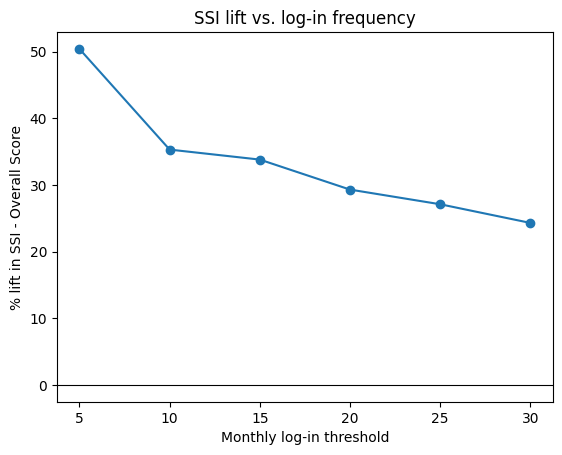

In [90]:
plt.plot(lift_table["threshold"], lift_table["lift_%"], marker="o")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Monthly log‑in threshold")
plt.ylabel("% lift in SSI - Overall Score")
plt.title("SSI lift vs. log‑in frequency")
plt.show()